In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import Union
import os
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# TL;DR Diffusion Model

- If we add steady amount of Gaussian noise repeated, eventually it will be corrupted into indistinguishable from a random Gaussian Sample
- Diffusion model learns to reverse the procedure

# Predicting original image


This is doing diffusion the "wrong" way by having the model predict the original image $x_0$. I implemented it as this is the most intuitive and I want to compare it with predicting the noise.

In [ ]:
def gather(x: torch.Tensor, t: Union[int, torch.Tensor]):
    if isinstance(t, int):
        t = torch.tensor([t], dtype=torch.long, device=x.device)
    elif isinstance(t, list):
        t = torch.tensor(t, dtype=torch.long, device=x.device)
    elif isinstance(t, torch.Tensor):
        t = t.to(dtype=torch.long, device=x.device)
    else:
        raise ValueError("Unsupported type for t")

    temp = x.gather(0, t)
    return temp.reshape(-1, 1, 1, 1)


class BasicDiffusion:
    def __init__(
        self,
        model: nn.Module,
        device: torch.device,
        n_steps=1000,
        beta_start=0.0001,
        beta_end=0.02,
    ):
        super().__init__()
        self.n_steps = n_steps
        self.betas = torch.linspace(beta_start, beta_end, n_steps).to(device)
        self.alpha = 1.0 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alpha, dim=0)

        # Compute alpha_cumprod_prev and posterior_variance
        self.alpha_cumprod_prev = torch.cat(
            [torch.ones(1, device=device), self.alpha_cumprod[:-1]]
        )
        self.posterior_variance = (
            (1.0 - self.alpha_cumprod_prev) / (1.0 - self.alpha_cumprod)
        ) * self.betas
        self.device = device
        self.model = model

    # q(xt|x0)
    def q(self, x_0, t):
        alpha_cumprod_t = gather(self.alpha_cumprod, t)
        mean = torch.sqrt(alpha_cumprod_t) * x_0
        var = 1.0 - alpha_cumprod_t
        return mean, var

    def q_sample(self, x_0, t, eps=None):
        if eps is None:
            eps = torch.randn_like(x_0)
        mean, var = self.q(x_0, t)
        return mean + torch.sqrt(var) * eps

    # p(x_t-1|x_t)
    def p_sample(self, x_t, t):
        x0_pred = self.model(x_t, t)

        alpha_bar_t = gather(self.alpha_cumprod, t)
        alpha_bar_prev_t = gather(self.alpha_cumprod_prev, t)
        alpha_t = gather(self.alpha, t)
        beta_t = gather(self.betas, t)

        mu_coef_x0 = (alpha_bar_prev_t.sqrt() * beta_t) / (1 - alpha_bar_t)
        mu_coef_xt = ((1 - alpha_bar_prev_t) * (1 - beta_t).sqrt()) / (1 - alpha_bar_t)
        # mu_coef_xt = (alpha_t.sqrt() * (1 - alpha_bar_prev_t)) / (1 - alpha_bar_t)

        mean = mu_coef_x0 * x0_pred + mu_coef_xt * x_t

        var = gather(self.posterior_variance, t)
        noise = torch.randn_like(x_t)
        mask = (t > 0).float()[:, None, None, None]
        x_t_prev = mean + torch.sqrt(var) * noise * mask

        return x_t_prev

    def loss(self, x0, noise=None):
        batch_size = x0.shape[0]
        t = torch.randint(0, self.n_steps, (batch_size,), device=x0.device).long()
        if noise is None:
            noise = torch.randn_like(x0)
        x_t = self.q_sample(x0, t, noise)
        x0_pred = self.model(x_t, t)
        return F.mse_loss(x0_pred, x0)

    def forward(self, x0, noise=None):
        return self.loss(x0, noise)

    def sample(self, n_samples=1, image_size=(1, 28, 28), xt=None):
        if xt is not None:
            x_t = xt.to(self.device)
        else:
            x_t = torch.randn(n_samples, *image_size).to(self.device)

        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((n_samples,), t, device=self.device, dtype=torch.long)
            x_t = self.p_sample(x_t, t_batch)  # assumes p_sample does noise addition

        return torch.clamp(x_t, -1.0, 1.0)

### Simple UNet implementaion for sanity check

In [ ]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.proj = nn.Sequential(nn.Linear(1, dim), nn.SiLU(), nn.Linear(dim, dim))

    def forward(self, t):
        # t: [B,] -> [B, dim]
        return self.proj(t.unsqueeze(-1).float())


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.norm = nn.BatchNorm2d(out_ch)

    def forward(self, x, t_emb):
        h = self.conv1(x)
        t_emb = self.time_mlp(t_emb).unsqueeze(-1).unsqueeze(-1)
        h = h + t_emb
        h = self.norm(h)
        h = F.silu(h)
        h = self.conv2(h)
        return h


class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_emb = TimeEmbedding(32)

        # Downsample
        self.down1 = Block(1, 32, 32)
        self.down2 = Block(32, 64, 32)
        self.down3 = Block(64, 128, 32)

        # Middle
        self.mid = Block(128, 128, 32)

        # Upsample
        self.up1 = Block(128 + 64, 64, 32)  # + skip connection
        self.up2 = Block(64 + 32, 32, 32)  # + skip connection
        self.up3 = Block(32, 1, 32)  # Final output

        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)

    def forward(self, x, t):
        t_emb = self.time_emb(t)

        # Downsample
        x1 = self.down1(x, t_emb)  # [B, 32, 28, 28]
        x2 = self.pool(x1)  # [B, 32, 14, 14]
        x3 = self.down2(x2, t_emb)  # [B, 64, 14, 14]
        x4 = self.pool(x3)  # [B, 64, 7, 7]
        x5 = self.down3(x4, t_emb)  # [B, 128, 7, 7]

        # Middle
        x6 = self.mid(x5, t_emb)  # [B, 128, 7, 7]

        # Upsample
        x7 = self.upsample(x6)  # [B, 128, 14, 14]
        x7 = torch.cat([x7, x3], dim=1)  # [B, 128+64=192, 14, 14]
        x8 = self.up1(x7, t_emb)  # [B, 64, 14, 14]

        x9 = self.upsample(x8)  # [B, 64, 28, 28]
        x9 = torch.cat([x9, x1], dim=1)  # [B, 64+32=96, 28, 28]
        x10 = self.up2(x9, t_emb)  # [B, 32, 28, 28]

        x11 = self.up3(x10, t_emb)  # [B, 1, 28, 28]
        return x11

In [ ]:
model = SimpleUNet()
total_params = sum(param.numel() for param in model.parameters())
print(total_params)

783246


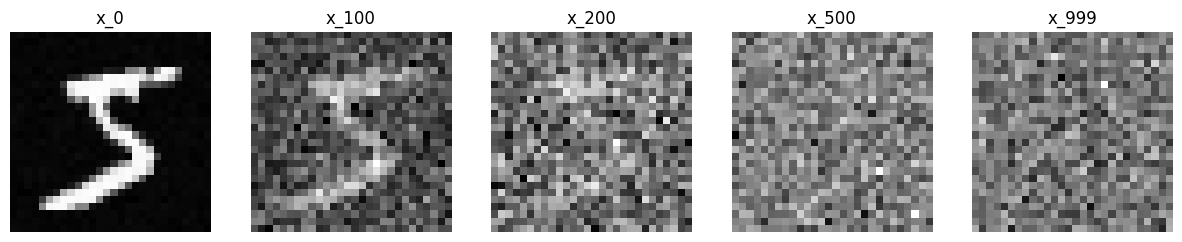

In [ ]:
from PIL import Image

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
np.random.seed(42)

os.makedirs("checkpoints", exist_ok=True)
os.makedirs("samples", exist_ok=True)

config = {
    "batch_size": 1280,
    "epochs": 100,
    "lr": 1e-4,
    "n_steps": 1000,
    "weight_decay": 1e-5,
    "max_grad_norm": 1.0,
    "save_interval": 50,
}

# Data augmentation
transform = transforms.Compose(
    [
        transforms.RandomRotation(5),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

# Initialization
model = SimpleUNet().to(device)
diffusion = BasicDiffusion(model, device, n_steps=config["n_steps"])
optimizer = torch.optim.Adam(
    model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"]
)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
sampled_image = dataloader.dataset.data[:1].unsqueeze(1).float() / 255.0

timesteps = [0, 100, 200, 500, 999]
sampled_images = []

for t in timesteps:
    sampled_image = diffusion.q_sample(
        sampled_image.unsqueeze(0).to(device), t=torch.tensor([t]).to(device)
    )
    sampled_images.append(sampled_image.squeeze().cpu())

# Plot the sampled images
plt.figure(figsize=(15, 3))
for i, (t, img) in enumerate(zip(timesteps, sampled_images)):
    plt.subplot(1, len(timesteps), i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"x_{t}")
    plt.axis("off")
plt.show()

Epoch 1/100: 100%|██████████| 47/47 [00:07<00:00,  6.12it/s, Loss=1.3028]


Epoch 1 | Avg Loss: 1.3185


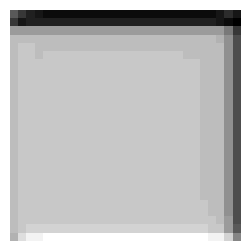

Epoch 2/100: 100%|██████████| 47/47 [00:07<00:00,  6.32it/s, Loss=1.2318]


Epoch 2 | Avg Loss: 1.2639


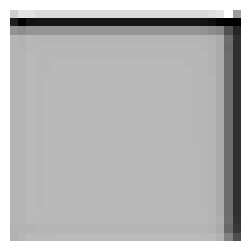

Epoch 3/100: 100%|██████████| 47/47 [00:07<00:00,  6.40it/s, Loss=1.1783]


Epoch 3 | Avg Loss: 1.2045


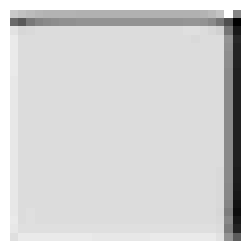

Epoch 4/100: 100%|██████████| 47/47 [00:07<00:00,  6.38it/s, Loss=1.1782]


Epoch 4 | Avg Loss: 1.1988


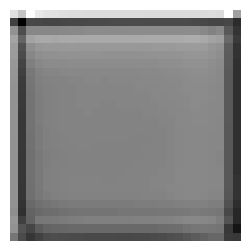

Epoch 5/100: 100%|██████████| 47/47 [00:07<00:00,  6.35it/s, Loss=1.1603]


Epoch 5 | Avg Loss: 1.1667


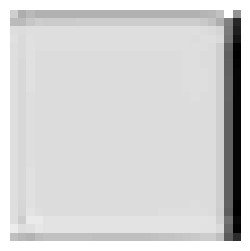

Epoch 6/100: 100%|██████████| 47/47 [00:07<00:00,  6.27it/s, Loss=1.1886]


Epoch 6 | Avg Loss: 1.1759


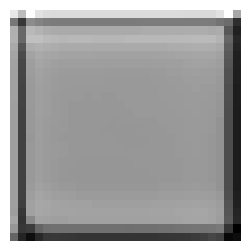

Epoch 7/100: 100%|██████████| 47/47 [00:07<00:00,  6.20it/s, Loss=1.2062]


Epoch 7 | Avg Loss: 1.1945


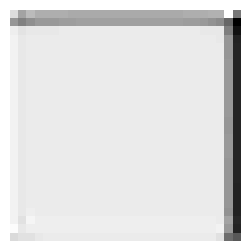

Epoch 8/100: 100%|██████████| 47/47 [00:07<00:00,  6.26it/s, Loss=1.1676]


Epoch 8 | Avg Loss: 1.1759


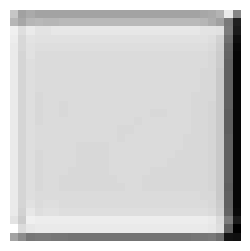

Epoch 9/100: 100%|██████████| 47/47 [00:07<00:00,  6.36it/s, Loss=1.1552]


Epoch 9 | Avg Loss: 1.1624


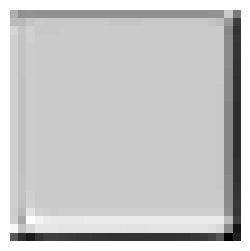

Epoch 10/100: 100%|██████████| 47/47 [00:07<00:00,  6.24it/s, Loss=1.1454]


Epoch 10 | Avg Loss: 1.1706


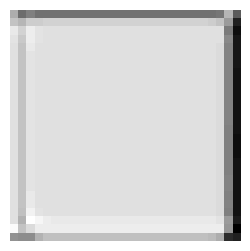

Epoch 11/100: 100%|██████████| 47/47 [00:07<00:00,  6.14it/s, Loss=1.1405]


Epoch 11 | Avg Loss: 1.1548


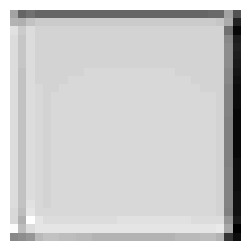

Epoch 12/100: 100%|██████████| 47/47 [00:07<00:00,  6.25it/s, Loss=1.1248]


Epoch 12 | Avg Loss: 1.1438


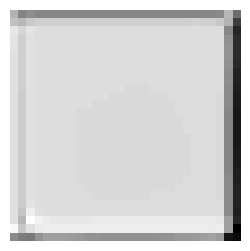

Epoch 13/100: 100%|██████████| 47/47 [00:07<00:00,  6.34it/s, Loss=1.1204]


Epoch 13 | Avg Loss: 1.1308


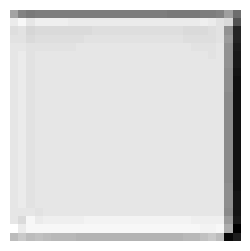

Epoch 14/100: 100%|██████████| 47/47 [00:07<00:00,  6.29it/s, Loss=1.1189]


Epoch 14 | Avg Loss: 1.1292


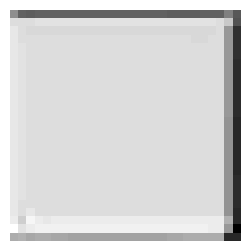

Epoch 15/100: 100%|██████████| 47/47 [00:07<00:00,  6.26it/s, Loss=1.1354]


Epoch 15 | Avg Loss: 1.1221


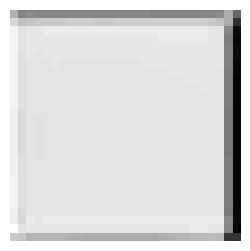

Epoch 16/100: 100%|██████████| 47/47 [00:07<00:00,  6.36it/s, Loss=1.0923]


Epoch 16 | Avg Loss: 1.1082


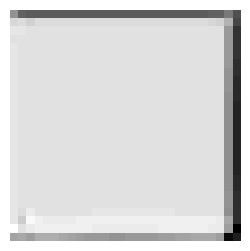

Epoch 17/100: 100%|██████████| 47/47 [00:07<00:00,  6.31it/s, Loss=1.0627]


Epoch 17 | Avg Loss: 1.0794


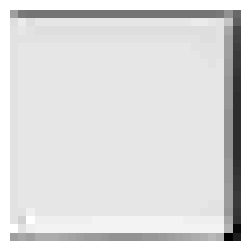

Epoch 18/100: 100%|██████████| 47/47 [00:07<00:00,  6.33it/s, Loss=1.0505]


Epoch 18 | Avg Loss: 1.0557


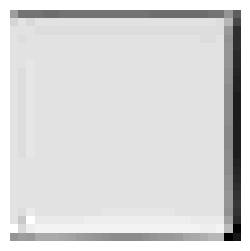

Epoch 19/100: 100%|██████████| 47/47 [00:07<00:00,  6.34it/s, Loss=1.0382]


Epoch 19 | Avg Loss: 1.0407


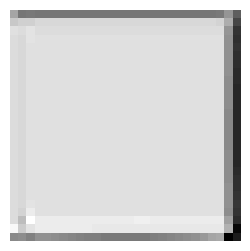

Epoch 20/100: 100%|██████████| 47/47 [00:07<00:00,  6.28it/s, Loss=1.0157]


Epoch 20 | Avg Loss: 1.0260


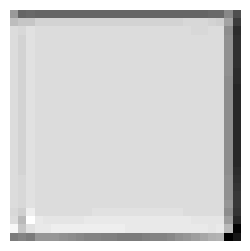

Epoch 21/100: 100%|██████████| 47/47 [00:07<00:00,  6.20it/s, Loss=1.0065]


Epoch 21 | Avg Loss: 1.0108


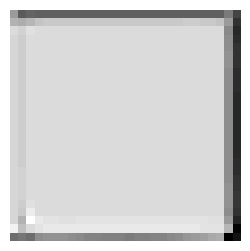

Epoch 22/100: 100%|██████████| 47/47 [00:07<00:00,  6.31it/s, Loss=0.9880]


Epoch 22 | Avg Loss: 0.9953


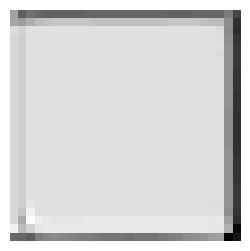

Epoch 23/100: 100%|██████████| 47/47 [00:07<00:00,  6.31it/s, Loss=0.9688]


Epoch 23 | Avg Loss: 0.9859


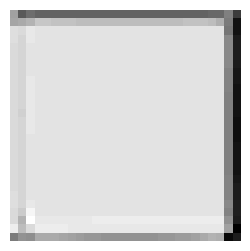

Epoch 24/100: 100%|██████████| 47/47 [00:07<00:00,  6.37it/s, Loss=0.9629]


Epoch 24 | Avg Loss: 0.9698


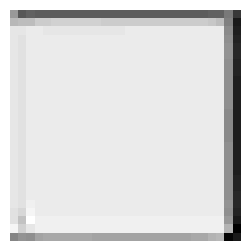

Epoch 25/100: 100%|██████████| 47/47 [00:07<00:00,  6.35it/s, Loss=0.9411]


Epoch 25 | Avg Loss: 0.9449


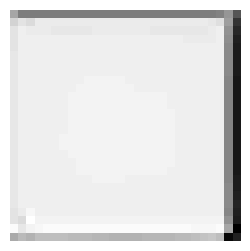

Epoch 26/100: 100%|██████████| 47/47 [00:07<00:00,  6.27it/s, Loss=0.9324]


Epoch 26 | Avg Loss: 0.9333


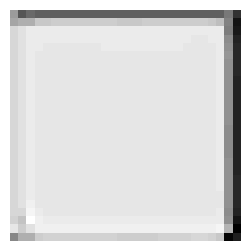

Epoch 27/100: 100%|██████████| 47/47 [00:07<00:00,  6.33it/s, Loss=0.9171]


Epoch 27 | Avg Loss: 0.9186


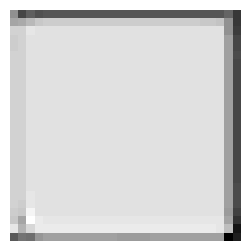

Epoch 28/100: 100%|██████████| 47/47 [00:07<00:00,  6.33it/s, Loss=0.8932]


Epoch 28 | Avg Loss: 0.9071


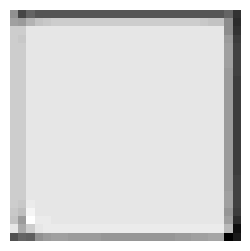

Epoch 29/100: 100%|██████████| 47/47 [00:07<00:00,  6.26it/s, Loss=0.8916]


Epoch 29 | Avg Loss: 0.8999


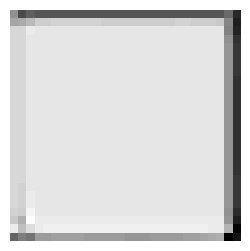

Epoch 30/100: 100%|██████████| 47/47 [00:07<00:00,  6.29it/s, Loss=0.8605]


Epoch 30 | Avg Loss: 0.8740


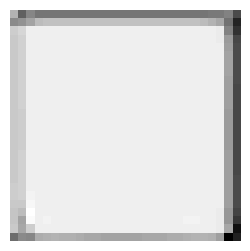

Epoch 31/100: 100%|██████████| 47/47 [00:07<00:00,  6.15it/s, Loss=0.8378]


Epoch 31 | Avg Loss: 0.8550


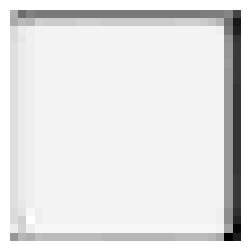

Epoch 32/100: 100%|██████████| 47/47 [00:07<00:00,  6.25it/s, Loss=0.8227]


Epoch 32 | Avg Loss: 0.8484


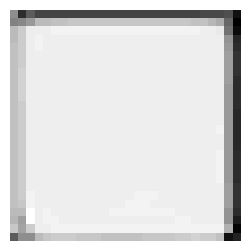

Epoch 33/100: 100%|██████████| 47/47 [00:07<00:00,  6.16it/s, Loss=0.8265]


Epoch 33 | Avg Loss: 0.8261


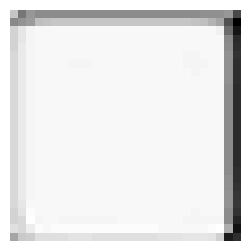

Epoch 34/100: 100%|██████████| 47/47 [00:07<00:00,  6.30it/s, Loss=0.7963]


Epoch 34 | Avg Loss: 0.8077


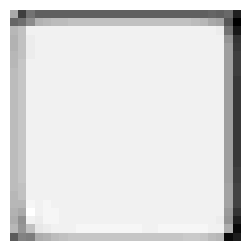

Epoch 35/100: 100%|██████████| 47/47 [00:07<00:00,  6.34it/s, Loss=0.7786]


Epoch 35 | Avg Loss: 0.7957


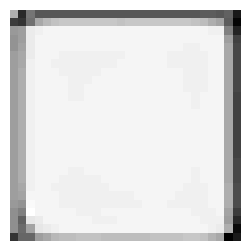

Epoch 36/100: 100%|██████████| 47/47 [00:07<00:00,  6.32it/s, Loss=0.7769]


Epoch 36 | Avg Loss: 0.7822


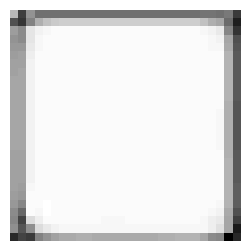

Epoch 37/100: 100%|██████████| 47/47 [00:07<00:00,  6.29it/s, Loss=0.7612]


Epoch 37 | Avg Loss: 0.7694


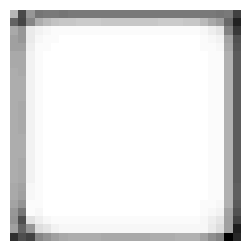

Epoch 38/100: 100%|██████████| 47/47 [00:07<00:00,  6.33it/s, Loss=0.7483]


Epoch 38 | Avg Loss: 0.7563


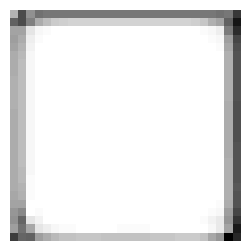

Epoch 39/100: 100%|██████████| 47/47 [00:07<00:00,  6.32it/s, Loss=0.7436]


Epoch 39 | Avg Loss: 0.7494


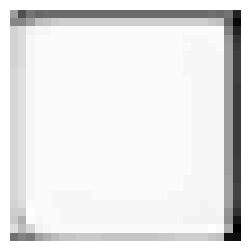

Epoch 40/100: 100%|██████████| 47/47 [00:07<00:00,  6.42it/s, Loss=0.7219]


Epoch 40 | Avg Loss: 0.7316


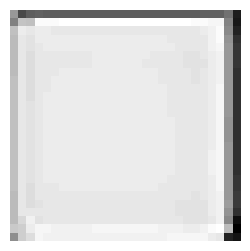

Epoch 41/100: 100%|██████████| 47/47 [00:07<00:00,  6.48it/s, Loss=0.6932]


Epoch 41 | Avg Loss: 0.7042


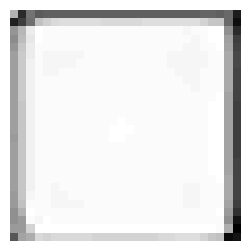

Epoch 42/100: 100%|██████████| 47/47 [00:07<00:00,  6.36it/s, Loss=0.6810]


Epoch 42 | Avg Loss: 0.6857


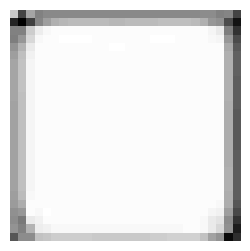

Epoch 43/100: 100%|██████████| 47/47 [00:07<00:00,  6.42it/s, Loss=0.6695]


Epoch 43 | Avg Loss: 0.6723


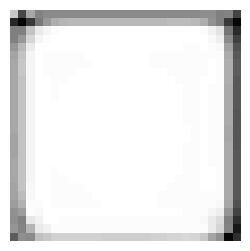

Epoch 44/100: 100%|██████████| 47/47 [00:07<00:00,  6.45it/s, Loss=0.6535]


Epoch 44 | Avg Loss: 0.6601


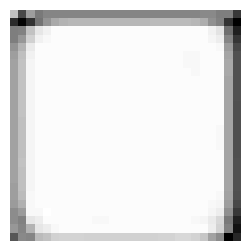

Epoch 45/100: 100%|██████████| 47/47 [00:07<00:00,  6.34it/s, Loss=0.6372]


Epoch 45 | Avg Loss: 0.6545


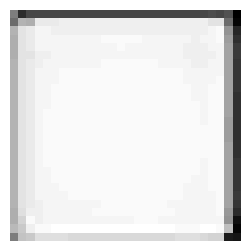

Epoch 46/100: 100%|██████████| 47/47 [00:07<00:00,  6.42it/s, Loss=0.6524]


Epoch 46 | Avg Loss: 0.6458


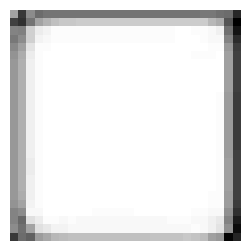

Epoch 47/100: 100%|██████████| 47/47 [00:07<00:00,  6.44it/s, Loss=0.6178]


Epoch 47 | Avg Loss: 0.6402


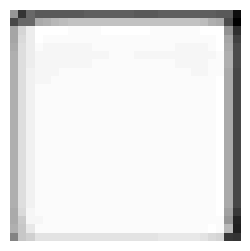

Epoch 48/100: 100%|██████████| 47/47 [00:07<00:00,  6.38it/s, Loss=0.6041]


Epoch 48 | Avg Loss: 0.6141


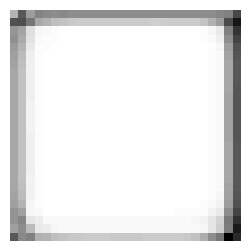

Epoch 49/100: 100%|██████████| 47/47 [00:07<00:00,  6.39it/s, Loss=0.5940]


Epoch 49 | Avg Loss: 0.5997


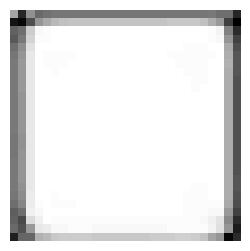

Epoch 50/100: 100%|██████████| 47/47 [00:07<00:00,  6.41it/s, Loss=0.5776]


Epoch 50 | Avg Loss: 0.5875


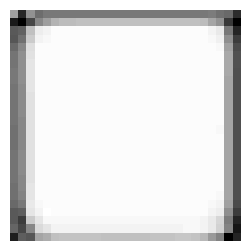

Epoch 51/100: 100%|██████████| 47/47 [00:07<00:00,  6.34it/s, Loss=0.5718]


Epoch 51 | Avg Loss: 0.5825


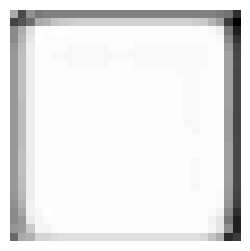

Epoch 52/100: 100%|██████████| 47/47 [00:07<00:00,  6.34it/s, Loss=0.5789]


Epoch 52 | Avg Loss: 0.5710


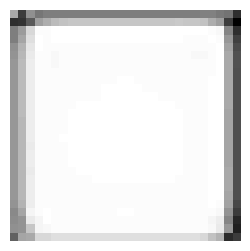

Epoch 53/100: 100%|██████████| 47/47 [00:07<00:00,  6.44it/s, Loss=0.5490]


Epoch 53 | Avg Loss: 0.5583


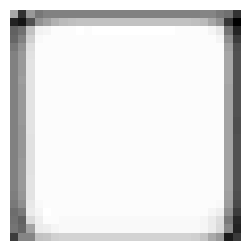

Epoch 54/100: 100%|██████████| 47/47 [00:07<00:00,  6.38it/s, Loss=0.5359]


Epoch 54 | Avg Loss: 0.5468


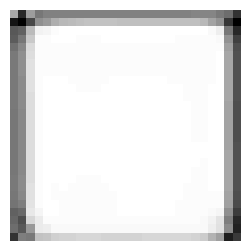

Epoch 55/100: 100%|██████████| 47/47 [00:07<00:00,  6.37it/s, Loss=0.5381]


Epoch 55 | Avg Loss: 0.5376


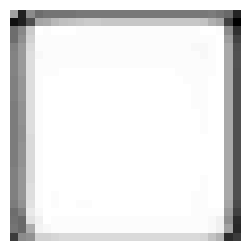

Epoch 56/100: 100%|██████████| 47/47 [00:07<00:00,  6.31it/s, Loss=0.5197]


Epoch 56 | Avg Loss: 0.5277


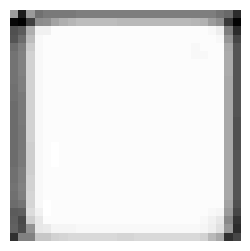

Epoch 57/100: 100%|██████████| 47/47 [00:07<00:00,  6.39it/s, Loss=0.5110]


Epoch 57 | Avg Loss: 0.5183


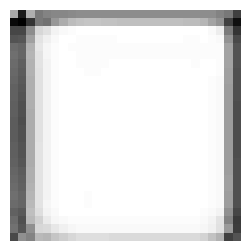

Epoch 58/100: 100%|██████████| 47/47 [00:07<00:00,  6.35it/s, Loss=0.5303]


Epoch 58 | Avg Loss: 0.5072


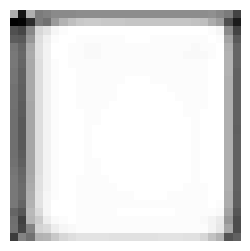

Epoch 59/100: 100%|██████████| 47/47 [00:07<00:00,  6.33it/s, Loss=0.5298]


Epoch 59 | Avg Loss: 0.5044


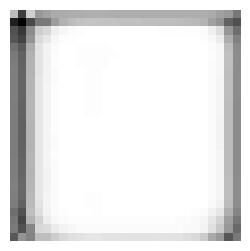

Epoch 60/100: 100%|██████████| 47/47 [00:07<00:00,  6.43it/s, Loss=0.4778]


Epoch 60 | Avg Loss: 0.4983


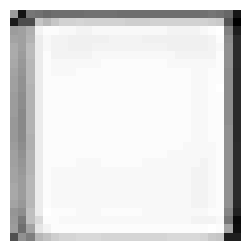

Epoch 61/100: 100%|██████████| 47/47 [00:07<00:00,  6.44it/s, Loss=0.4847]


Epoch 61 | Avg Loss: 0.4765


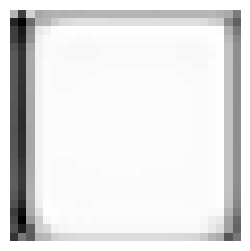

Epoch 62/100: 100%|██████████| 47/47 [00:07<00:00,  6.33it/s, Loss=0.4469]


Epoch 62 | Avg Loss: 0.4600


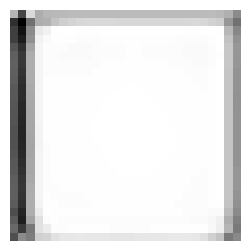

Epoch 63/100: 100%|██████████| 47/47 [00:07<00:00,  6.31it/s, Loss=0.4314]


Epoch 63 | Avg Loss: 0.4405


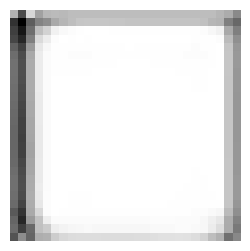

Epoch 64/100: 100%|██████████| 47/47 [00:07<00:00,  6.31it/s, Loss=0.4223]


Epoch 64 | Avg Loss: 0.4259


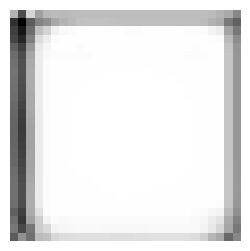

Epoch 65/100: 100%|██████████| 47/47 [00:07<00:00,  6.29it/s, Loss=0.4030]


Epoch 65 | Avg Loss: 0.4143


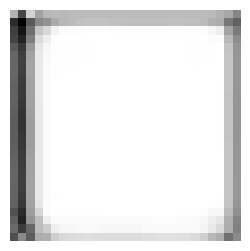

Epoch 66/100: 100%|██████████| 47/47 [00:07<00:00,  6.31it/s, Loss=0.4025]


Epoch 66 | Avg Loss: 0.4052


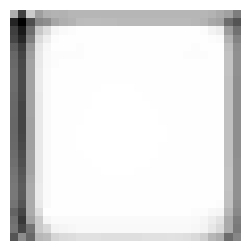

Epoch 67/100: 100%|██████████| 47/47 [00:07<00:00,  6.27it/s, Loss=0.3884]


Epoch 67 | Avg Loss: 0.3951


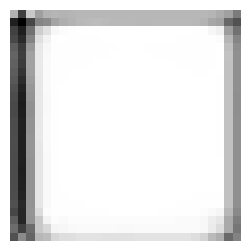

Epoch 68/100: 100%|██████████| 47/47 [00:07<00:00,  6.24it/s, Loss=0.3807]


Epoch 68 | Avg Loss: 0.3867


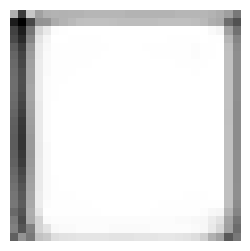

Epoch 69/100: 100%|██████████| 47/47 [00:07<00:00,  6.47it/s, Loss=0.3718]


Epoch 69 | Avg Loss: 0.3794


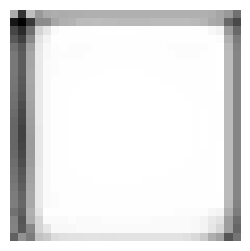

Epoch 70/100: 100%|██████████| 47/47 [00:07<00:00,  6.39it/s, Loss=0.3741]


Epoch 70 | Avg Loss: 0.3720


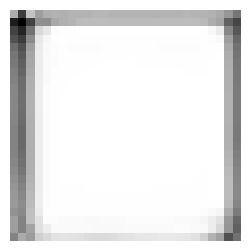

Epoch 71/100: 100%|██████████| 47/47 [00:07<00:00,  6.57it/s, Loss=0.3538]


Epoch 71 | Avg Loss: 0.3634


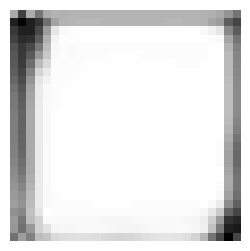

Epoch 72/100: 100%|██████████| 47/47 [00:07<00:00,  6.36it/s, Loss=0.3500]


Epoch 72 | Avg Loss: 0.3562


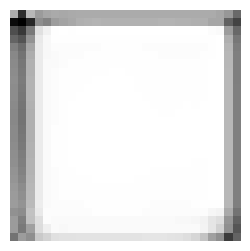

Epoch 73/100: 100%|██████████| 47/47 [00:07<00:00,  6.20it/s, Loss=0.3407]


Epoch 73 | Avg Loss: 0.3471


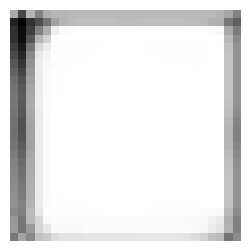

Epoch 74/100: 100%|██████████| 47/47 [00:07<00:00,  6.39it/s, Loss=0.3372]


Epoch 74 | Avg Loss: 0.3399


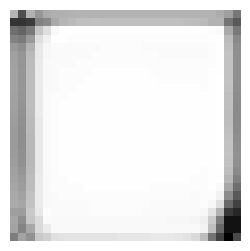

Epoch 75/100: 100%|██████████| 47/47 [00:07<00:00,  6.50it/s, Loss=0.3293]


Epoch 75 | Avg Loss: 0.3340


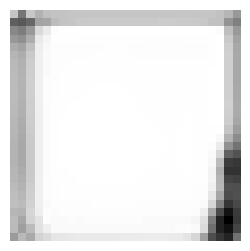

Epoch 76/100: 100%|██████████| 47/47 [00:07<00:00,  6.54it/s, Loss=0.3230]


Epoch 76 | Avg Loss: 0.3272


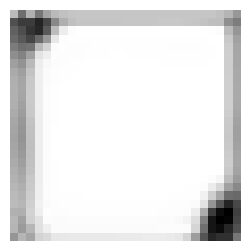

Epoch 77/100: 100%|██████████| 47/47 [00:07<00:00,  6.50it/s, Loss=0.3146]


Epoch 77 | Avg Loss: 0.3217


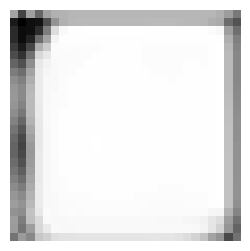

Epoch 78/100: 100%|██████████| 47/47 [00:07<00:00,  6.44it/s, Loss=0.3111]


Epoch 78 | Avg Loss: 0.3154


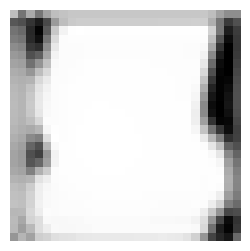

Epoch 79/100: 100%|██████████| 47/47 [00:07<00:00,  6.56it/s, Loss=0.3058]


Epoch 79 | Avg Loss: 0.3097


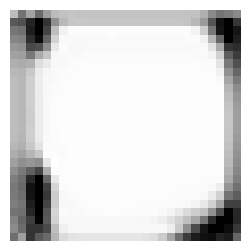

Epoch 80/100: 100%|██████████| 47/47 [00:07<00:00,  6.57it/s, Loss=0.3005]


Epoch 80 | Avg Loss: 0.3046


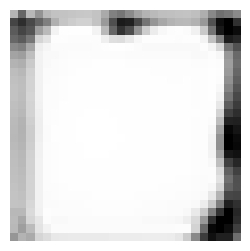

Epoch 81/100: 100%|██████████| 47/47 [00:07<00:00,  6.47it/s, Loss=0.2987]


Epoch 81 | Avg Loss: 0.2981


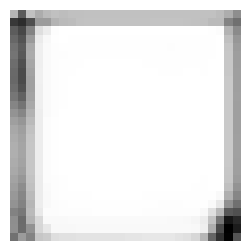

Epoch 82/100: 100%|██████████| 47/47 [00:07<00:00,  6.59it/s, Loss=0.3014]


Epoch 82 | Avg Loss: 0.2940


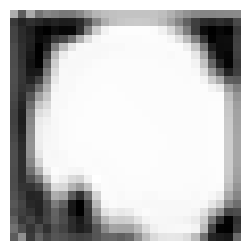

Epoch 83/100: 100%|██████████| 47/47 [00:07<00:00,  6.42it/s, Loss=0.3096]


Epoch 83 | Avg Loss: 0.3086


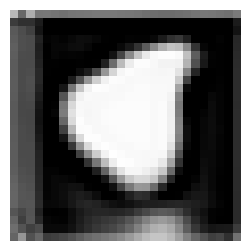

Epoch 84/100: 100%|██████████| 47/47 [00:07<00:00,  6.39it/s, Loss=0.2920]


Epoch 84 | Avg Loss: 0.3034


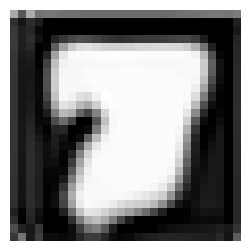

Epoch 85/100: 100%|██████████| 47/47 [00:07<00:00,  6.31it/s, Loss=0.2974]


Epoch 85 | Avg Loss: 0.2940


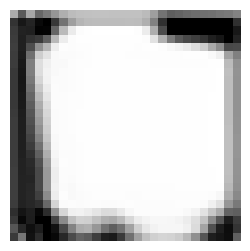

Epoch 86/100: 100%|██████████| 47/47 [00:07<00:00,  6.51it/s, Loss=0.2913]


Epoch 86 | Avg Loss: 0.2900


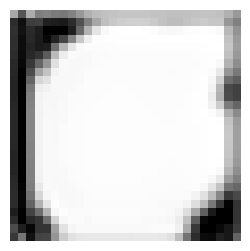

Epoch 87/100: 100%|██████████| 47/47 [00:07<00:00,  6.34it/s, Loss=0.2835]


Epoch 87 | Avg Loss: 0.2876


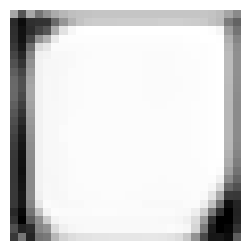

Epoch 88/100: 100%|██████████| 47/47 [00:07<00:00,  6.50it/s, Loss=0.3070]


Epoch 88 | Avg Loss: 0.2887


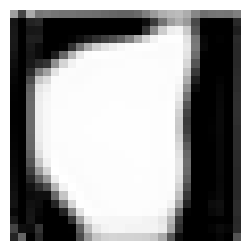

Epoch 89/100: 100%|██████████| 47/47 [00:07<00:00,  6.64it/s, Loss=0.2722]


Epoch 89 | Avg Loss: 0.2838


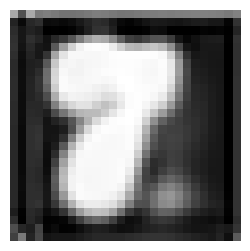

Epoch 90/100: 100%|██████████| 47/47 [00:07<00:00,  6.51it/s, Loss=0.2686]


Epoch 90 | Avg Loss: 0.2764


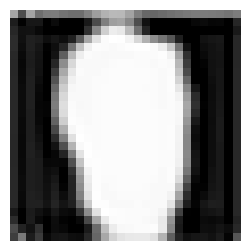

Epoch 91/100: 100%|██████████| 47/47 [00:07<00:00,  6.59it/s, Loss=0.2760]


Epoch 91 | Avg Loss: 0.2730


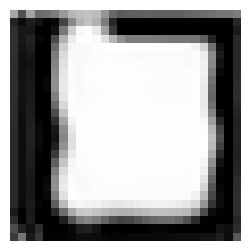

Epoch 92/100: 100%|██████████| 47/47 [00:07<00:00,  6.58it/s, Loss=0.2736]


Epoch 92 | Avg Loss: 0.2680


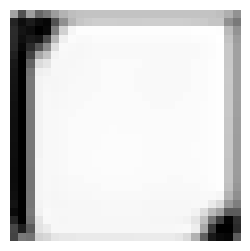

Epoch 93/100: 100%|██████████| 47/47 [00:07<00:00,  6.55it/s, Loss=0.2575]


Epoch 93 | Avg Loss: 0.2651


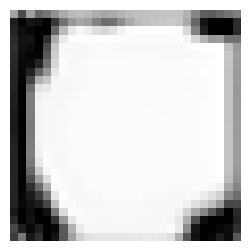

Epoch 94/100: 100%|██████████| 47/47 [00:07<00:00,  6.58it/s, Loss=0.2581]


Epoch 94 | Avg Loss: 0.2623


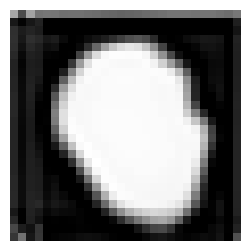

Epoch 95/100: 100%|██████████| 47/47 [00:07<00:00,  6.62it/s, Loss=0.2583]


Epoch 95 | Avg Loss: 0.2531


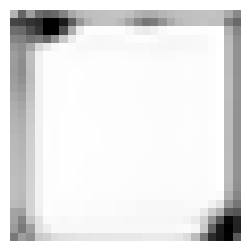

Epoch 96/100: 100%|██████████| 47/47 [00:07<00:00,  6.54it/s, Loss=0.2394]


Epoch 96 | Avg Loss: 0.2513


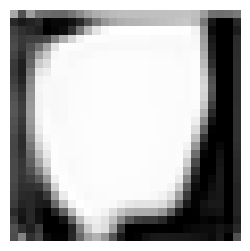

Epoch 97/100: 100%|██████████| 47/47 [00:07<00:00,  6.54it/s, Loss=0.2375]


Epoch 97 | Avg Loss: 0.2395


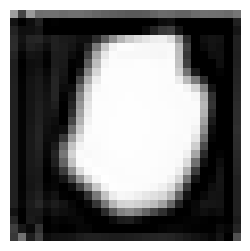

Epoch 98/100: 100%|██████████| 47/47 [00:07<00:00,  6.52it/s, Loss=0.2333]


Epoch 98 | Avg Loss: 0.2357


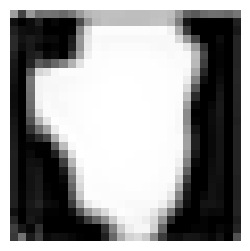

Epoch 99/100: 100%|██████████| 47/47 [00:07<00:00,  6.39it/s, Loss=0.2243]


Epoch 99 | Avg Loss: 0.2329


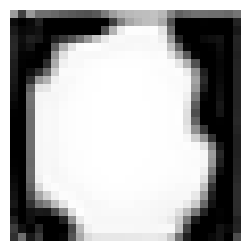

Epoch 100/100: 100%|██████████| 47/47 [00:07<00:00,  6.52it/s, Loss=0.2283]


Epoch 100 | Avg Loss: 0.2290


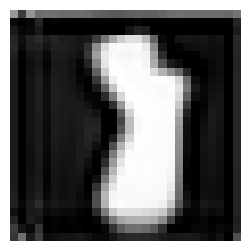

Training completed!


In [ ]:
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
best_loss = float("inf")
for epoch in range(config["epochs"]):
    model.train()
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{config['epochs']}")
    total_loss = 0

    for images, _ in pbar:
        images = images.to(device)

        # Training step
        optimizer.zero_grad()
        loss = diffusion.loss(images)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), config["max_grad_norm"]
        )  # prevent gradient exploding
        optimizer.step()

        # Logging
        total_loss += loss.item()
        pbar.set_postfix({"Loss": f"{loss.item():.4f}"})

    # scheduler.step()
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1} | Avg Loss: {avg_loss:.4f}")

    # Generate and save sample image
    model.eval()
    with torch.no_grad():
        # Generate 1 sample
        sampled_images = diffusion.sample(n_samples=1)

        # Convert tensor to image
        img = sampled_images[0].cpu().squeeze()  # Remove batch and channel dims
        img = (img + 1) * 127.5  # Scale from [-1,1] to [0,255]
        img = img.numpy().astype(np.uint8)
        plt.figure(figsize=(3, 3))
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.show()
        Image.fromarray(img).save(f"samples/epoch_{epoch+1:03d}.png")

    if (epoch + 1) % config["save_interval"] == 0:
        torch.save(
            {
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "loss": avg_loss,
            },
            f"checkpoints/checkpoint_{epoch+1:03d}.pth",
        )

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), "checkpoints/best_model.pth")


torch.save(model.state_dict(), "mnist_diffusion_final.pth")
print("Training completed!")

Epoch 101/100: 100%|██████████| 47/47 [00:08<00:00,  5.53it/s, Loss=0.2144]


Epoch 1 | Avg Loss: 0.2074


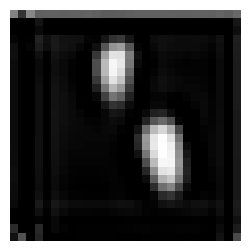

Epoch 102/100: 100%|██████████| 47/47 [00:08<00:00,  5.53it/s, Loss=0.2177]


Epoch 2 | Avg Loss: 0.2172


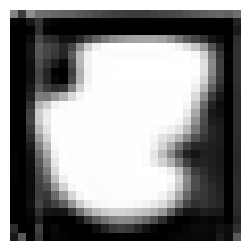

Epoch 103/100: 100%|██████████| 47/47 [00:08<00:00,  5.56it/s, Loss=0.2091]


Epoch 3 | Avg Loss: 0.2200


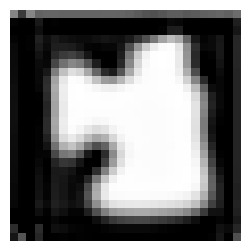

Epoch 104/100: 100%|██████████| 47/47 [00:08<00:00,  5.56it/s, Loss=0.2121]


Epoch 4 | Avg Loss: 0.2120


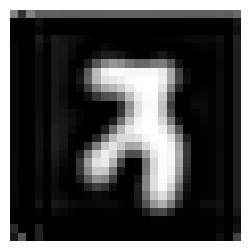

Epoch 105/100: 100%|██████████| 47/47 [00:08<00:00,  5.53it/s, Loss=0.2076]


Epoch 5 | Avg Loss: 0.2103


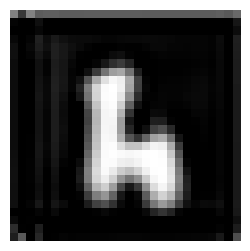

Epoch 106/100: 100%|██████████| 47/47 [00:08<00:00,  5.57it/s, Loss=0.2094]


Epoch 6 | Avg Loss: 0.2065


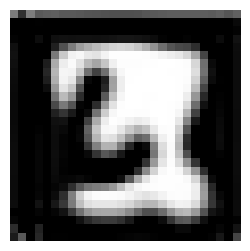

Epoch 107/100: 100%|██████████| 47/47 [00:08<00:00,  5.57it/s, Loss=0.2067]


Epoch 7 | Avg Loss: 0.2044


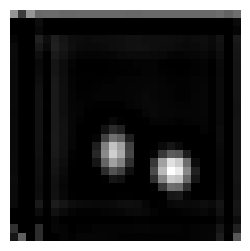

Epoch 108/100: 100%|██████████| 47/47 [00:08<00:00,  5.62it/s, Loss=0.1970]


Epoch 8 | Avg Loss: 0.2025


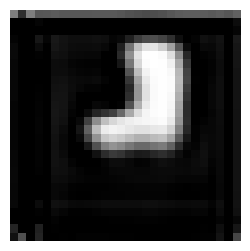

Epoch 109/100: 100%|██████████| 47/47 [00:08<00:00,  5.61it/s, Loss=0.2042]


Epoch 9 | Avg Loss: 0.2027


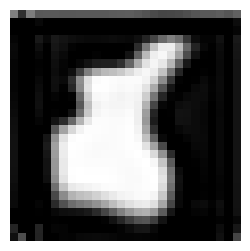

Epoch 110/100: 100%|██████████| 47/47 [00:08<00:00,  5.62it/s, Loss=0.2019]


Epoch 10 | Avg Loss: 0.2023


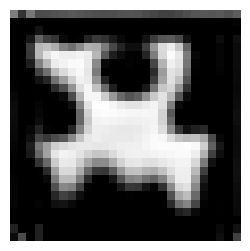

Training completed!


In [ ]:
"""
# another 10 epochs
for epoch in range(10):
    model.train()
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+101}/{config['epochs']}")
    total_loss = 0

    for images, _ in pbar:
        images = images.to(device)

        # Training step
        optimizer.zero_grad()
        #with torch.amp.autocast("cuda", enabled=True):
        loss = diffusion.loss(images)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config['max_grad_norm']) # prevent gradient exploding
        optimizer.step()

        # Logging
        total_loss += loss.item()
        pbar.set_postfix({"Loss": f"{loss.item():.4f}"})


    #scheduler.step()
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1} | Avg Loss: {avg_loss:.4f}")

    # Generate and save sample image
    model.eval()
    with torch.no_grad():
        # Generate 1 sample
        sampled_images = diffusion.sample(n_samples=1)

        # Convert tensor to image
        img = sampled_images[0].cpu().squeeze()  # Remove batch and channel dims
        img = (img + 1) * 127.5  # Scale from [-1,1] to [0,255]
        img = img.numpy().astype(np.uint8)
        plt.figure(figsize=(3, 3))
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.show()
        Image.fromarray(img).save(f"samples/epoch_{epoch+1:03d}.png")

    if (epoch + 1) % config['save_interval'] == 0:
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': avg_loss,
        }, f"checkpoints/checkpoint_{epoch+1:03d}.pth")

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), "checkpoints/best_model.pth")


torch.save(model.state_dict(), "mnist_diffusion_final.pth")
print("Training completed!")
"""

Epoch 111/210: 100%|██████████| 47/47 [00:08<00:00,  5.55it/s, Loss=0.2164]


Epoch 1 | Avg Loss: 0.2073


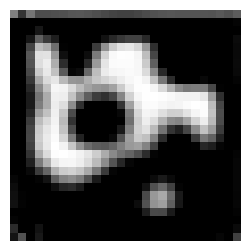

Epoch 112/210: 100%|██████████| 47/47 [00:08<00:00,  5.63it/s, Loss=0.2111]


Epoch 2 | Avg Loss: 0.2147


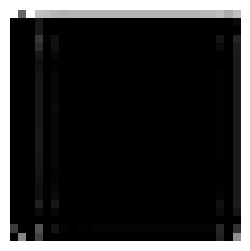

Epoch 113/210: 100%|██████████| 47/47 [00:08<00:00,  5.56it/s, Loss=0.2041]


Epoch 3 | Avg Loss: 0.2135


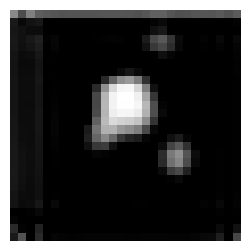

Epoch 114/210: 100%|██████████| 47/47 [00:08<00:00,  5.50it/s, Loss=0.1974]


Epoch 4 | Avg Loss: 0.2043


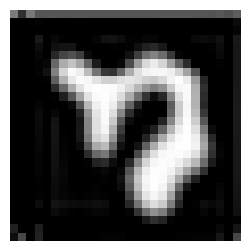

Epoch 115/210: 100%|██████████| 47/47 [00:08<00:00,  5.55it/s, Loss=0.2005]


Epoch 5 | Avg Loss: 0.2016


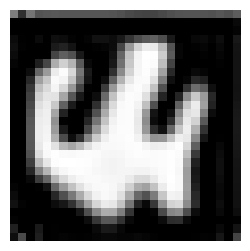

Epoch 116/210: 100%|██████████| 47/47 [00:08<00:00,  5.54it/s, Loss=0.2054]


Epoch 6 | Avg Loss: 0.2005


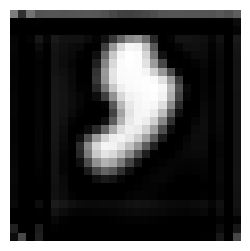

Epoch 117/210: 100%|██████████| 47/47 [00:08<00:00,  5.48it/s, Loss=0.2055]


Epoch 7 | Avg Loss: 0.2006


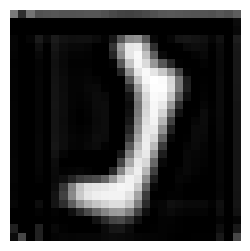

Epoch 118/210: 100%|██████████| 47/47 [00:08<00:00,  5.54it/s, Loss=0.1979]


Epoch 8 | Avg Loss: 0.1999


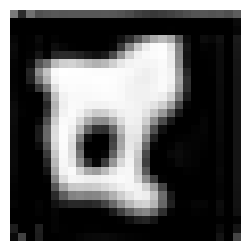

Epoch 119/210: 100%|██████████| 47/47 [00:08<00:00,  5.55it/s, Loss=0.2001]


Epoch 9 | Avg Loss: 0.1994


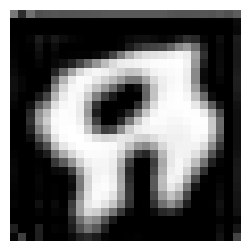

Epoch 120/210: 100%|██████████| 47/47 [00:08<00:00,  5.50it/s, Loss=0.1970]


Epoch 10 | Avg Loss: 0.1986


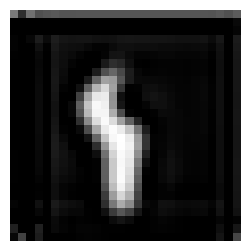

Epoch 121/210: 100%|██████████| 47/47 [00:08<00:00,  5.56it/s, Loss=0.1976]


Epoch 11 | Avg Loss: 0.1983


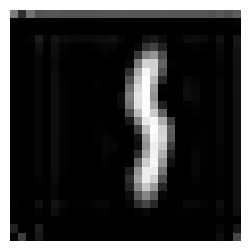

Epoch 122/210: 100%|██████████| 47/47 [00:08<00:00,  5.59it/s, Loss=0.2034]


Epoch 12 | Avg Loss: 0.1972


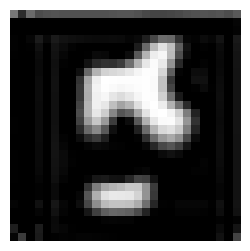

Epoch 123/210: 100%|██████████| 47/47 [00:08<00:00,  5.53it/s, Loss=0.2044]


Epoch 13 | Avg Loss: 0.1986


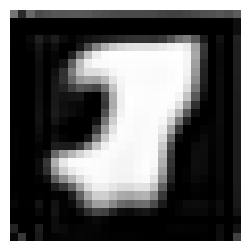

Epoch 124/210: 100%|██████████| 47/47 [00:08<00:00,  5.60it/s, Loss=0.1957]


Epoch 14 | Avg Loss: 0.2019


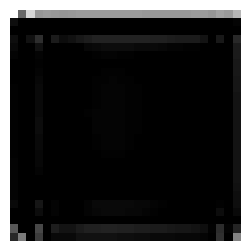

Epoch 125/210: 100%|██████████| 47/47 [00:08<00:00,  5.64it/s, Loss=0.2181]


Epoch 15 | Avg Loss: 0.2070


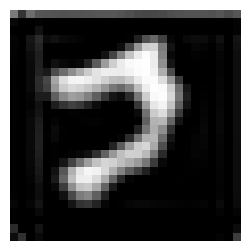

Epoch 126/210: 100%|██████████| 47/47 [00:08<00:00,  5.59it/s, Loss=0.2066]


Epoch 16 | Avg Loss: 0.2052


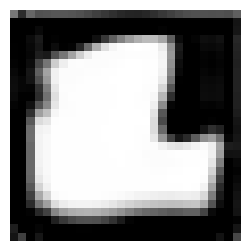

Epoch 127/210: 100%|██████████| 47/47 [00:08<00:00,  5.62it/s, Loss=0.1950]


Epoch 17 | Avg Loss: 0.2018


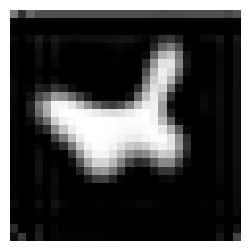

Epoch 128/210: 100%|██████████| 47/47 [00:08<00:00,  5.54it/s, Loss=0.2008]


Epoch 18 | Avg Loss: 0.1984


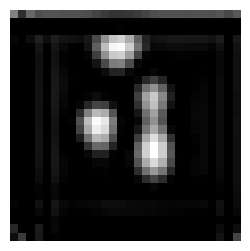

Epoch 129/210: 100%|██████████| 47/47 [00:08<00:00,  5.48it/s, Loss=0.1922]


Epoch 19 | Avg Loss: 0.1976


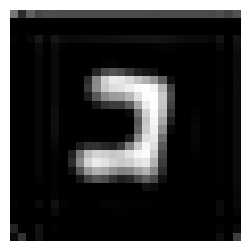

Epoch 130/210: 100%|██████████| 47/47 [00:08<00:00,  5.52it/s, Loss=0.2007]


Epoch 20 | Avg Loss: 0.1967


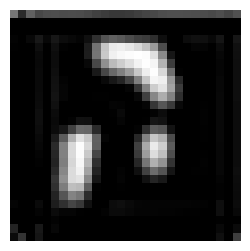

Epoch 131/210: 100%|██████████| 47/47 [00:08<00:00,  5.61it/s, Loss=0.2023]


Epoch 21 | Avg Loss: 0.1972


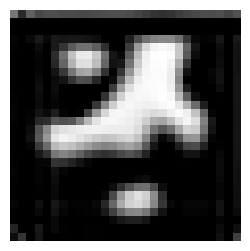

Epoch 132/210: 100%|██████████| 47/47 [00:08<00:00,  5.55it/s, Loss=0.1981]


Epoch 22 | Avg Loss: 0.1977


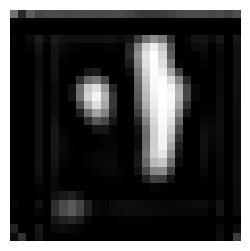

Epoch 133/210: 100%|██████████| 47/47 [00:08<00:00,  5.56it/s, Loss=0.1908]


Epoch 23 | Avg Loss: 0.1968


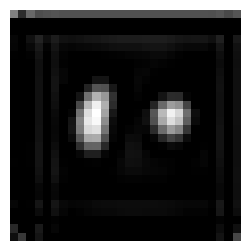

Epoch 134/210: 100%|██████████| 47/47 [00:08<00:00,  5.57it/s, Loss=0.1973]


Epoch 24 | Avg Loss: 0.1958


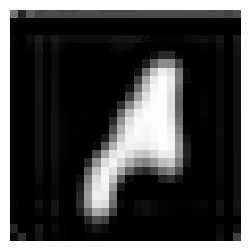

Epoch 135/210: 100%|██████████| 47/47 [00:08<00:00,  5.53it/s, Loss=0.1942]


Epoch 25 | Avg Loss: 0.1958


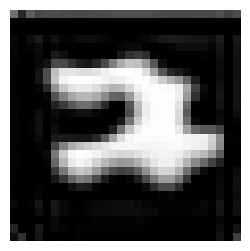

Epoch 136/210: 100%|██████████| 47/47 [00:08<00:00,  5.56it/s, Loss=0.1891]


Epoch 26 | Avg Loss: 0.1946


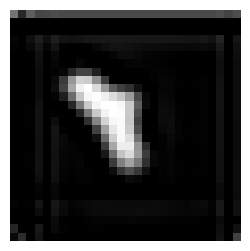

Epoch 137/210: 100%|██████████| 47/47 [00:08<00:00,  5.59it/s, Loss=0.1897]


Epoch 27 | Avg Loss: 0.1948


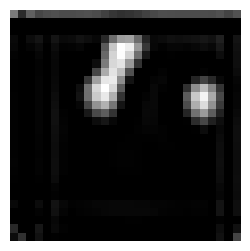

Epoch 138/210: 100%|██████████| 47/47 [00:08<00:00,  5.48it/s, Loss=0.1888]


Epoch 28 | Avg Loss: 0.1945


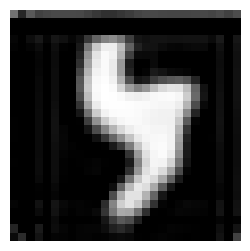

Epoch 139/210: 100%|██████████| 47/47 [00:08<00:00,  5.54it/s, Loss=0.1982]


Epoch 29 | Avg Loss: 0.1977


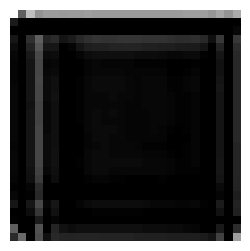

Epoch 140/210: 100%|██████████| 47/47 [00:08<00:00,  5.53it/s, Loss=0.2021]


Epoch 30 | Avg Loss: 0.2036


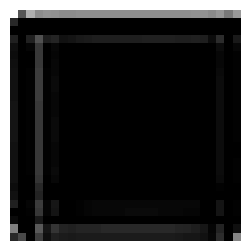

Epoch 141/210: 100%|██████████| 47/47 [00:08<00:00,  5.55it/s, Loss=0.1951]


Epoch 31 | Avg Loss: 0.1986


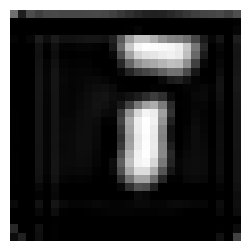

Epoch 142/210: 100%|██████████| 47/47 [00:08<00:00,  5.49it/s, Loss=0.1984]


Epoch 32 | Avg Loss: 0.1960


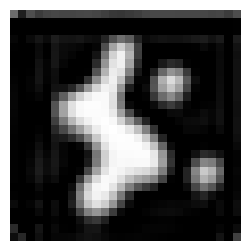

Epoch 143/210: 100%|██████████| 47/47 [00:08<00:00,  5.52it/s, Loss=0.1917]


Epoch 33 | Avg Loss: 0.1946


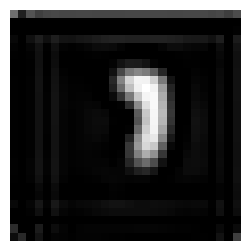

Epoch 144/210: 100%|██████████| 47/47 [00:08<00:00,  5.48it/s, Loss=0.1961]


Epoch 34 | Avg Loss: 0.1941


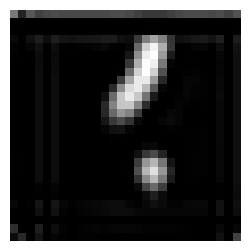

Epoch 145/210: 100%|██████████| 47/47 [00:08<00:00,  5.54it/s, Loss=0.1963]


Epoch 35 | Avg Loss: 0.1929


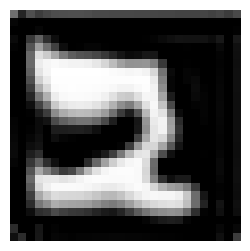

Epoch 146/210: 100%|██████████| 47/47 [00:08<00:00,  5.58it/s, Loss=0.1891]


Epoch 36 | Avg Loss: 0.1930


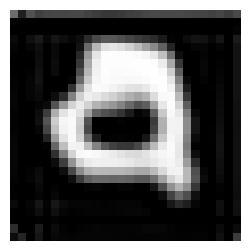

Epoch 147/210: 100%|██████████| 47/47 [00:08<00:00,  5.59it/s, Loss=0.1988]


Epoch 37 | Avg Loss: 0.1934


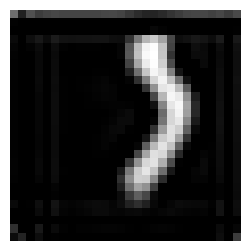

Epoch 148/210: 100%|██████████| 47/47 [00:08<00:00,  5.55it/s, Loss=0.2040]


Epoch 38 | Avg Loss: 0.1996


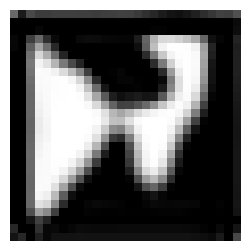

Epoch 149/210: 100%|██████████| 47/47 [00:08<00:00,  5.62it/s, Loss=0.1992]


Epoch 39 | Avg Loss: 0.1982


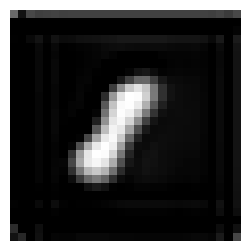

Epoch 150/210: 100%|██████████| 47/47 [00:08<00:00,  5.65it/s, Loss=0.1913]


Epoch 40 | Avg Loss: 0.1963


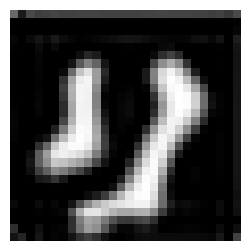

Epoch 151/210: 100%|██████████| 47/47 [00:08<00:00,  5.60it/s, Loss=0.1965]


Epoch 41 | Avg Loss: 0.1962


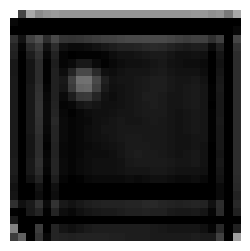

Epoch 152/210: 100%|██████████| 47/47 [00:08<00:00,  5.64it/s, Loss=0.1971]


Epoch 42 | Avg Loss: 0.1968


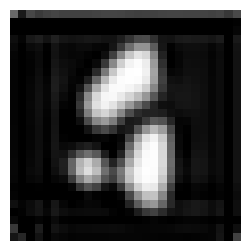

Epoch 153/210: 100%|██████████| 47/47 [00:08<00:00,  5.62it/s, Loss=0.1934]


Epoch 43 | Avg Loss: 0.1933


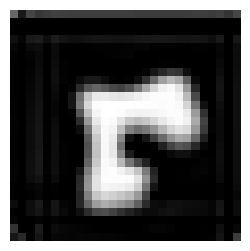

Epoch 154/210: 100%|██████████| 47/47 [00:08<00:00,  5.48it/s, Loss=0.1904]


Epoch 44 | Avg Loss: 0.1915


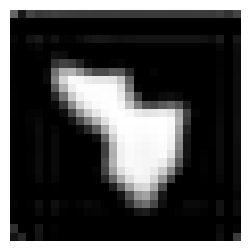

Epoch 155/210: 100%|██████████| 47/47 [00:08<00:00,  5.57it/s, Loss=0.1837]


Epoch 45 | Avg Loss: 0.1919


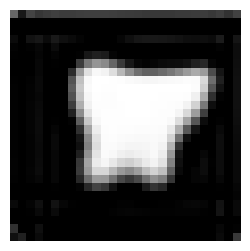

Epoch 156/210: 100%|██████████| 47/47 [00:08<00:00,  5.57it/s, Loss=0.1904]


Epoch 46 | Avg Loss: 0.1923


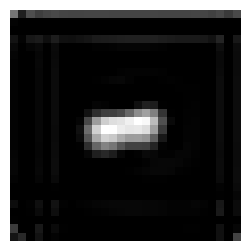

Epoch 157/210: 100%|██████████| 47/47 [00:08<00:00,  5.54it/s, Loss=0.1926]


Epoch 47 | Avg Loss: 0.1914


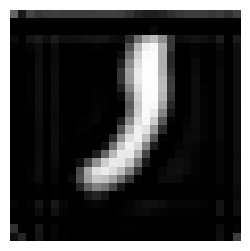

Epoch 158/210: 100%|██████████| 47/47 [00:08<00:00,  5.60it/s, Loss=0.1873]


Epoch 48 | Avg Loss: 0.1911


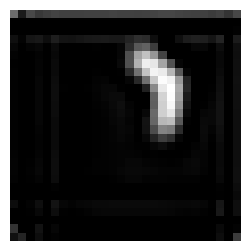

Epoch 159/210: 100%|██████████| 47/47 [00:08<00:00,  5.60it/s, Loss=0.1869]


Epoch 49 | Avg Loss: 0.1908


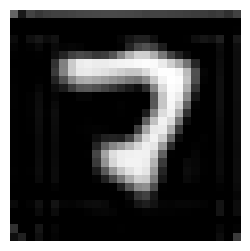

Epoch 160/210: 100%|██████████| 47/47 [00:08<00:00,  5.56it/s, Loss=0.1913]


Epoch 50 | Avg Loss: 0.1905


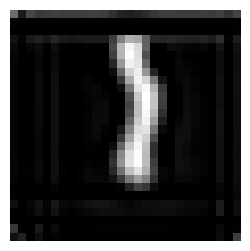

Epoch 161/210: 100%|██████████| 47/47 [00:08<00:00,  5.54it/s, Loss=0.1918]


Epoch 51 | Avg Loss: 0.1910


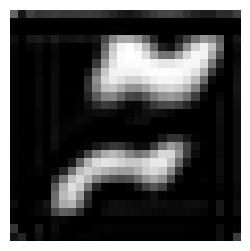

Epoch 162/210: 100%|██████████| 47/47 [00:08<00:00,  5.59it/s, Loss=0.1921]


Epoch 52 | Avg Loss: 0.1910


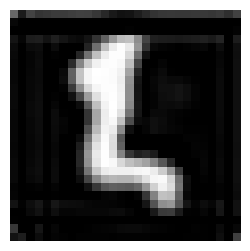

Epoch 163/210: 100%|██████████| 47/47 [00:08<00:00,  5.57it/s, Loss=0.1959]


Epoch 53 | Avg Loss: 0.1923


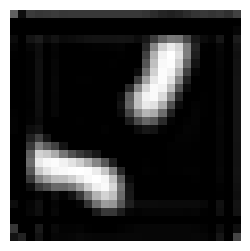

Epoch 164/210: 100%|██████████| 47/47 [00:08<00:00,  5.57it/s, Loss=0.1886]


Epoch 54 | Avg Loss: 0.1943


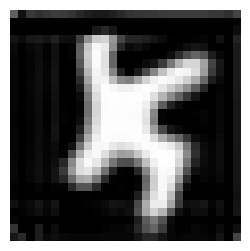

Epoch 165/210: 100%|██████████| 47/47 [00:08<00:00,  5.57it/s, Loss=0.1866]


Epoch 55 | Avg Loss: 0.1900


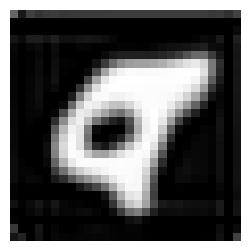

Epoch 166/210: 100%|██████████| 47/47 [00:08<00:00,  5.49it/s, Loss=0.1874]


Epoch 56 | Avg Loss: 0.1902


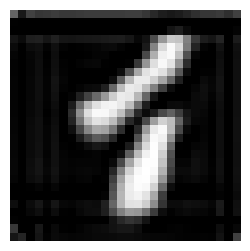

Epoch 167/210: 100%|██████████| 47/47 [00:08<00:00,  5.53it/s, Loss=0.1915]


Epoch 57 | Avg Loss: 0.1907


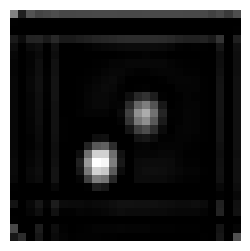

Epoch 168/210: 100%|██████████| 47/47 [00:08<00:00,  5.49it/s, Loss=0.1898]


Epoch 58 | Avg Loss: 0.1885


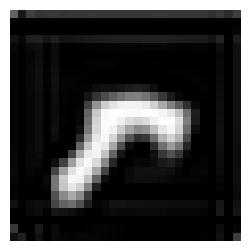

Epoch 169/210: 100%|██████████| 47/47 [00:08<00:00,  5.54it/s, Loss=0.1899]


Epoch 59 | Avg Loss: 0.1894


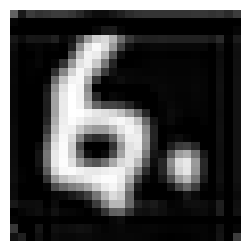

Epoch 170/210: 100%|██████████| 47/47 [00:08<00:00,  5.56it/s, Loss=0.1902]


Epoch 60 | Avg Loss: 0.1905


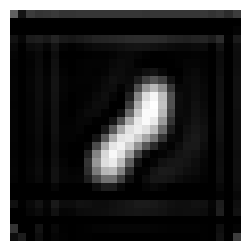

Epoch 171/210: 100%|██████████| 47/47 [00:08<00:00,  5.54it/s, Loss=0.1888]


Epoch 61 | Avg Loss: 0.1887


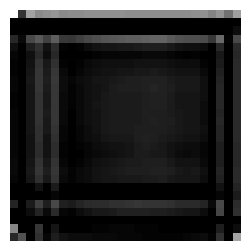

Epoch 172/210: 100%|██████████| 47/47 [00:08<00:00,  5.50it/s, Loss=0.1848]


Epoch 62 | Avg Loss: 0.1881


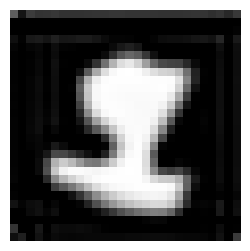

Epoch 173/210: 100%|██████████| 47/47 [00:08<00:00,  5.61it/s, Loss=0.1923]


Epoch 63 | Avg Loss: 0.1882


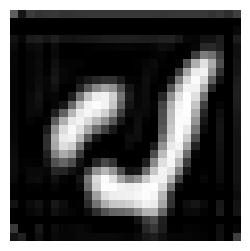

Epoch 174/210: 100%|██████████| 47/47 [00:08<00:00,  5.55it/s, Loss=0.1834]


Epoch 64 | Avg Loss: 0.1880


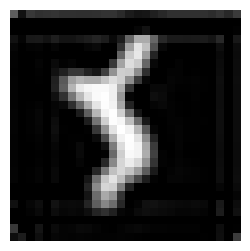

Epoch 175/210: 100%|██████████| 47/47 [00:08<00:00,  5.52it/s, Loss=0.1938]


Epoch 65 | Avg Loss: 0.1919


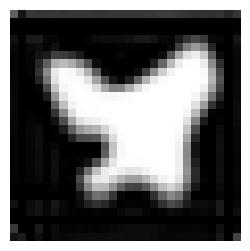

Epoch 176/210: 100%|██████████| 47/47 [00:08<00:00,  5.58it/s, Loss=0.1884]


Epoch 66 | Avg Loss: 0.1905


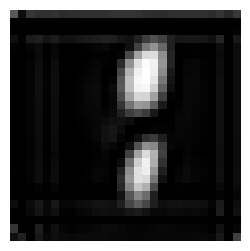

Epoch 177/210: 100%|██████████| 47/47 [00:08<00:00,  5.58it/s, Loss=0.1885]


Epoch 67 | Avg Loss: 0.1881


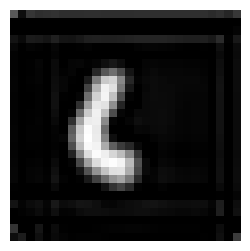

Epoch 178/210: 100%|██████████| 47/47 [00:08<00:00,  5.54it/s, Loss=0.1885]


Epoch 68 | Avg Loss: 0.1870


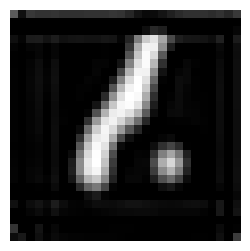

Epoch 179/210: 100%|██████████| 47/47 [00:08<00:00,  5.59it/s, Loss=0.1897]


Epoch 69 | Avg Loss: 0.1868


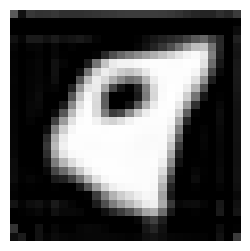

Epoch 180/210: 100%|██████████| 47/47 [00:08<00:00,  5.60it/s, Loss=0.1823]


Epoch 70 | Avg Loss: 0.1868


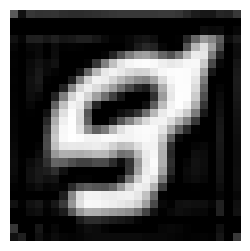

Epoch 181/210: 100%|██████████| 47/47 [00:08<00:00,  5.55it/s, Loss=0.1822]


Epoch 71 | Avg Loss: 0.1863


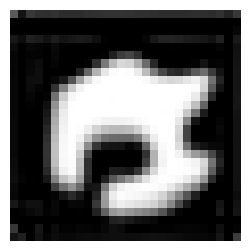

Epoch 182/210: 100%|██████████| 47/47 [00:08<00:00,  5.59it/s, Loss=0.1892]


Epoch 72 | Avg Loss: 0.1880


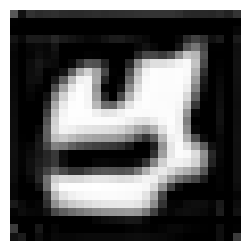

Epoch 183/210: 100%|██████████| 47/47 [00:08<00:00,  5.59it/s, Loss=0.1832]


Epoch 73 | Avg Loss: 0.1873


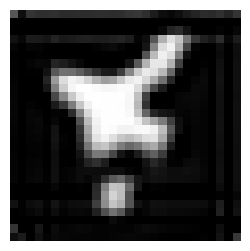

Epoch 184/210: 100%|██████████| 47/47 [00:08<00:00,  5.58it/s, Loss=0.1863]


Epoch 74 | Avg Loss: 0.1862


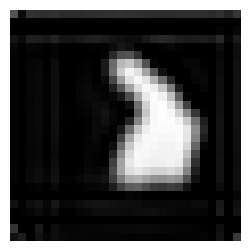

Epoch 185/210: 100%|██████████| 47/47 [00:08<00:00,  5.54it/s, Loss=0.1904]


Epoch 75 | Avg Loss: 0.1947


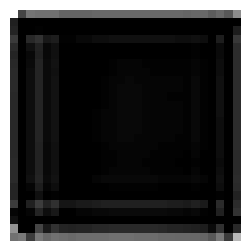

Epoch 186/210: 100%|██████████| 47/47 [00:08<00:00,  5.56it/s, Loss=0.1972]


Epoch 76 | Avg Loss: 0.1935


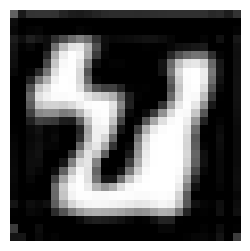

Epoch 187/210: 100%|██████████| 47/47 [00:08<00:00,  5.60it/s, Loss=0.1811]


Epoch 77 | Avg Loss: 0.1894


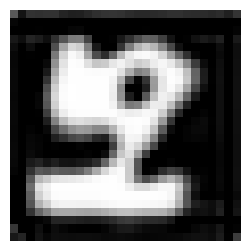

Epoch 188/210: 100%|██████████| 47/47 [00:08<00:00,  5.53it/s, Loss=0.1859]


Epoch 78 | Avg Loss: 0.1865


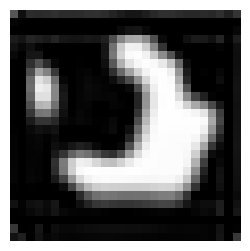

Epoch 189/210: 100%|██████████| 47/47 [00:08<00:00,  5.59it/s, Loss=0.1848]


Epoch 79 | Avg Loss: 0.1856


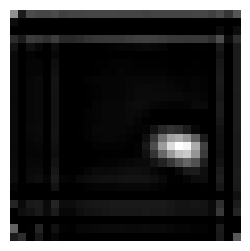

Epoch 190/210: 100%|██████████| 47/47 [00:08<00:00,  5.61it/s, Loss=0.1860]


Epoch 80 | Avg Loss: 0.1865


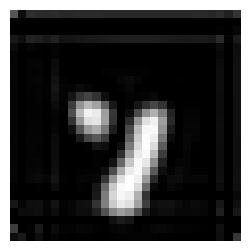

Epoch 191/210: 100%|██████████| 47/47 [00:08<00:00,  5.56it/s, Loss=0.1835]


Epoch 81 | Avg Loss: 0.1859


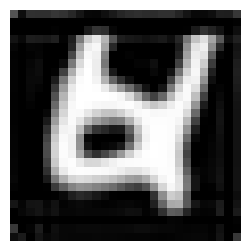

Epoch 192/210: 100%|██████████| 47/47 [00:08<00:00,  5.61it/s, Loss=0.1867]


Epoch 82 | Avg Loss: 0.1850


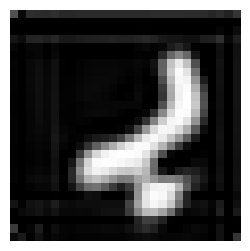

Epoch 193/210: 100%|██████████| 47/47 [00:08<00:00,  5.56it/s, Loss=0.1801]


Epoch 83 | Avg Loss: 0.1850


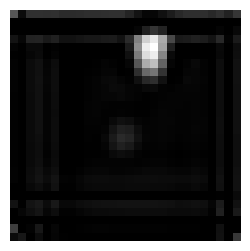

Epoch 194/210: 100%|██████████| 47/47 [00:08<00:00,  5.60it/s, Loss=0.1833]


Epoch 84 | Avg Loss: 0.1851


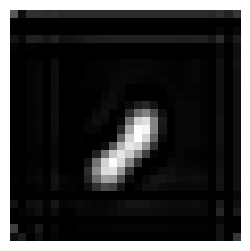

Epoch 195/210: 100%|██████████| 47/47 [00:08<00:00,  5.63it/s, Loss=0.1883]


Epoch 85 | Avg Loss: 0.1846


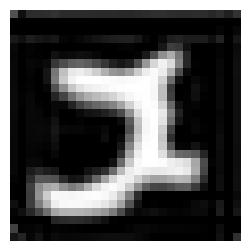

Epoch 196/210: 100%|██████████| 47/47 [00:08<00:00,  5.63it/s, Loss=0.1854]


Epoch 86 | Avg Loss: 0.1869


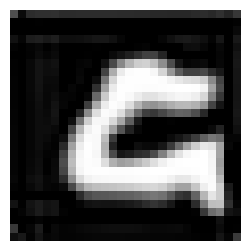

Epoch 197/210: 100%|██████████| 47/47 [00:08<00:00,  5.57it/s, Loss=0.1932]


Epoch 87 | Avg Loss: 0.1851


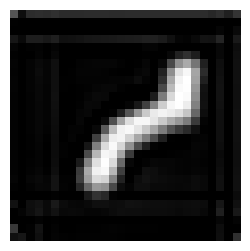

Epoch 198/210: 100%|██████████| 47/47 [00:08<00:00,  5.65it/s, Loss=0.1795]


Epoch 88 | Avg Loss: 0.1827


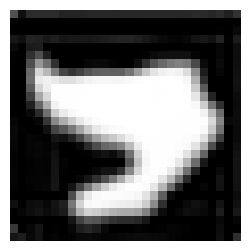

Epoch 199/210: 100%|██████████| 47/47 [00:08<00:00,  5.63it/s, Loss=0.1846]


Epoch 89 | Avg Loss: 0.1840


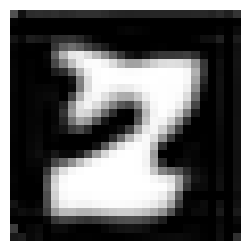

Epoch 200/210: 100%|██████████| 47/47 [00:08<00:00,  5.48it/s, Loss=0.1913]


Epoch 90 | Avg Loss: 0.1848


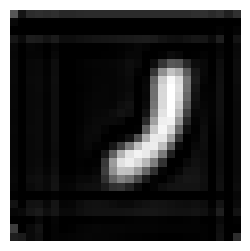

Epoch 201/210: 100%|██████████| 47/47 [00:08<00:00,  5.55it/s, Loss=0.1817]


Epoch 91 | Avg Loss: 0.1863


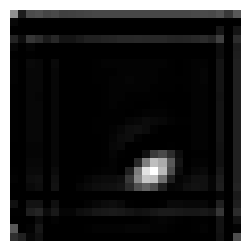

Epoch 202/210: 100%|██████████| 47/47 [00:08<00:00,  5.60it/s, Loss=0.1875]


Epoch 92 | Avg Loss: 0.1852


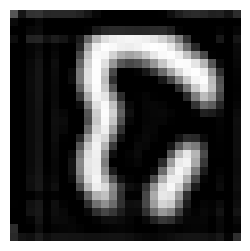

Epoch 203/210: 100%|██████████| 47/47 [00:08<00:00,  5.51it/s, Loss=0.1739]


Epoch 93 | Avg Loss: 0.1833


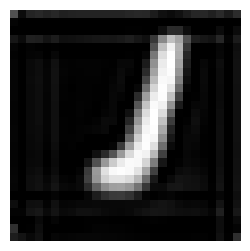

Epoch 204/210: 100%|██████████| 47/47 [00:08<00:00,  5.58it/s, Loss=0.1801]


Epoch 94 | Avg Loss: 0.1817


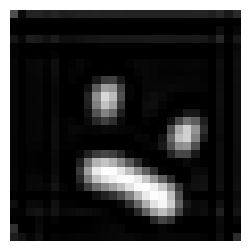

Epoch 205/210: 100%|██████████| 47/47 [00:08<00:00,  5.59it/s, Loss=0.1883]


Epoch 95 | Avg Loss: 0.1815


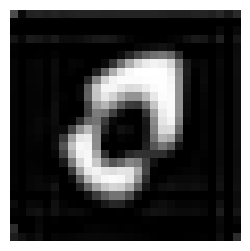

Epoch 206/210: 100%|██████████| 47/47 [00:08<00:00,  5.46it/s, Loss=0.1843]


Epoch 96 | Avg Loss: 0.1821


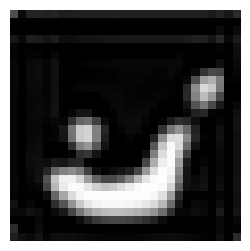

Epoch 207/210: 100%|██████████| 47/47 [00:08<00:00,  5.50it/s, Loss=0.1832]


Epoch 97 | Avg Loss: 0.1809


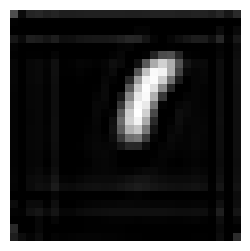

Epoch 208/210: 100%|██████████| 47/47 [00:08<00:00,  5.46it/s, Loss=0.1751]


Epoch 98 | Avg Loss: 0.1808


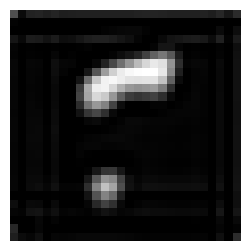

Epoch 209/210: 100%|██████████| 47/47 [00:08<00:00,  5.54it/s, Loss=0.1826]


Epoch 99 | Avg Loss: 0.1821


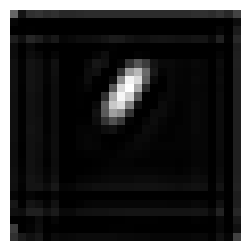

Epoch 210/210: 100%|██████████| 47/47 [00:08<00:00,  5.53it/s, Loss=0.1782]


Epoch 100 | Avg Loss: 0.1845


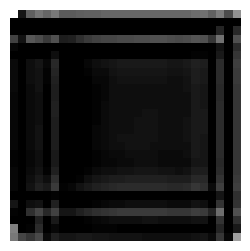

Training completed!


In [ ]:
"""
# another 100 epochs
for epoch in range(100):
    model.train()
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+111}/210")
    total_loss = 0

    for images, _ in pbar:
        images = images.to(device)

        # Training step
        optimizer.zero_grad()
        #with torch.amp.autocast("cuda", enabled=True):
        loss = diffusion.loss(images)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config['max_grad_norm']) # prevent gradient exploding
        optimizer.step()

        # Logging
        total_loss += loss.item()
        pbar.set_postfix({"Loss": f"{loss.item():.4f}"})


    #scheduler.step()
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1} | Avg Loss: {avg_loss:.4f}")

    # Generate and save sample image
    model.eval()
    with torch.no_grad():
        # Generate 1 sample
        sampled_images = diffusion.sample(n_samples=1)

        # Convert tensor to image
        img = sampled_images[0].cpu().squeeze()  # Remove batch and channel dims
        img = (img + 1) * 127.5  # Scale from [-1,1] to [0,255]
        img = img.numpy().astype(np.uint8)
        plt.figure(figsize=(3, 3))
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.show()
        Image.fromarray(img).save(f"samples/epoch_{epoch+1:03d}.png")

    if (epoch + 1) % config['save_interval'] == 0:
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': avg_loss,
        }, f"checkpoints/checkpoint_{epoch+1:03d}.pth")

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), "checkpoints/best_model.pth")


torch.save(model.state_dict(), "mnist_diffusion_final.pth")
print("Training completed!")
"""

In [ ]:
print(best_loss)

0.18084813337376776
